In [69]:
from streamlit_app import Trace, JsonDec
import json, os
import pandas as pd
import datetime as dt
import inspect

In [19]:
downloads = "C:\\Users\\holge\\Downloads"
for fn in os.listdir(downloads):
    if fn.endswith(".json"):
        print(fn)


traces (1).json
traces (2).json
traces.json


In [46]:
traces = list()
with open(os.path.join(downloads, "traces (2).json")) as file:
    for trace_dict in json.load(file, cls=JsonDec)["content"]:
        trace = Trace(**trace_dict)
        trace.xs = [dt.datetime.fromisoformat(x) for x in trace.xs]
        traces.append(trace)
len(traces)


1

In [47]:
trace = traces[0]
trace

Trace(entity='disk_use_percent', unit='%', name='duse', line_mode='markers', is_cumsum=False, is_diff=False)

In [48]:
s1 = pd.Series(data=trace.ys, index=trace.xs, name=trace.entity)
s1

2024-01-02 16:00:00+00:00    3.654545
2024-01-05 11:00:00+00:00    3.614286
2024-01-05 12:00:00+00:00    3.800000
2024-01-05 13:00:00+00:00    3.750000
2024-01-05 14:00:00+00:00    3.750000
                               ...   
2024-04-24 03:00:00+00:00    4.450000
2024-05-02 05:00:00+00:00    4.500000
2024-05-02 06:00:00+00:00    4.400000
2024-05-08 15:00:00+00:00    4.450000
2024-05-12 02:00:00+00:00    4.712500
Name: disk_use_percent, Length: 486, dtype: float64

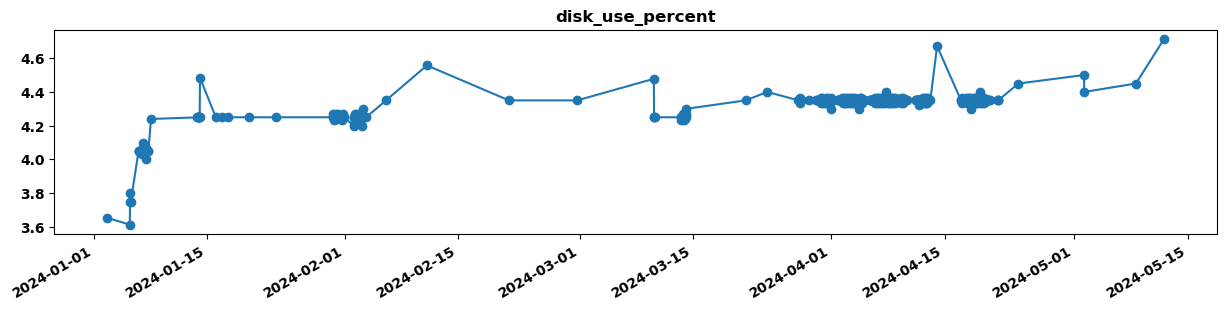

In [50]:
%matplotlib inline
s1.plot(figsize=(15,3), style="o-", title=s1.name);

In [72]:
class SignalTransformers():
    @staticmethod
    def diff(input_series: pd.Series) -> pd.Series:
        output_series = input_series.diff()
        output_series.name += ".diff"
        return output_series
    
    @staticmethod
    def cumsum(input_series: pd.Series) -> pd.Series:
        output_series = input_series.cumsum()
        output_series.name += ".cumsum"
        return output_series
    
    @staticmethod
    def resample(input_series: pd.Series, interval_days: float = 1.0, agg_sum: bool = False, fill_na: bool = False) -> pd.Series:
        resampler = input_series.resample(dt.timedelta(days=interval_days))
        if interval_days.is_integer():
            name_adder = f".res{int(interval_days)}d_"
        else:
            interval_hours = interval_days * 24
            if interval_hours.is_integer():
                name_adder = f".res{int(interval_hours)}h_"
            else:
                name_adder = f".res{interval_hours}h_"   
                
        if agg_sum:
            output_series = resampler.sum()
            output_series.name += name_adder + "sum"
        if fill_na:
            output_series =  resampler.mean().ffill()
            output_series.name += name_adder + "mean_fill"
        else:
            output_series =  resampler.mean()
            output_series.name += name_adder + "mean"
        return output_series
    

In [73]:
print("Available transformers:")
for trans_name in dir(SignalTransformers):
    if not trans_name.startswith("_"):
        print(f"- {trans_name}")
        transformer = getattr(SignalTransformers, trans_name)
        signature = inspect.signature(transformer)
        print(f"\t{signature=}")

Available transformers:
- cumsum
	signature=<Signature (input_series: pandas.core.series.Series) -> pandas.core.series.Series>
- diff
	signature=<Signature (input_series: pandas.core.series.Series) -> pandas.core.series.Series>
- resample
	signature=<Signature (input_series: pandas.core.series.Series, interval_days: float = 1.0, agg_sum: bool = False, fill_na: bool = False) -> pandas.core.series.Series>


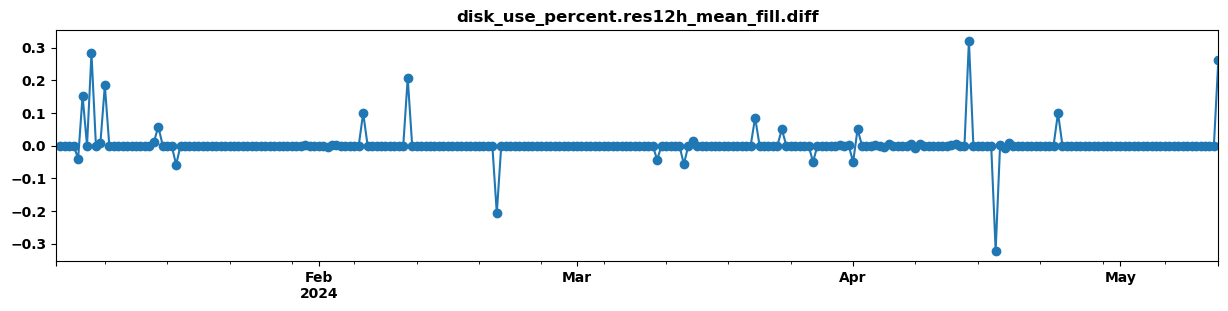

In [76]:
s2 = SignalTransformers.resample(s1, interval_days=0.5, fill_na=True)
s3 = SignalTransformers.diff(s2)
s3.plot(figsize=(15,3), style="o-", title=s3.name);